# Large Scale Bayesian Inference of Log-Gaussian Cox Processes with Expectation Propagation for Traffic Density Estimation Problem

Use Environment: lgcp.

RBF Kernel for the Prior.

# Generate road scenario

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gp import sample_from_GP
from tikzplotlib import save as tikz_save

In [2]:
# Road geometry
segment_length = 0.2 # meters
n_segments = 100 # number of segments
xs = np.linspace(0, segment_length * n_segments, n_segments)

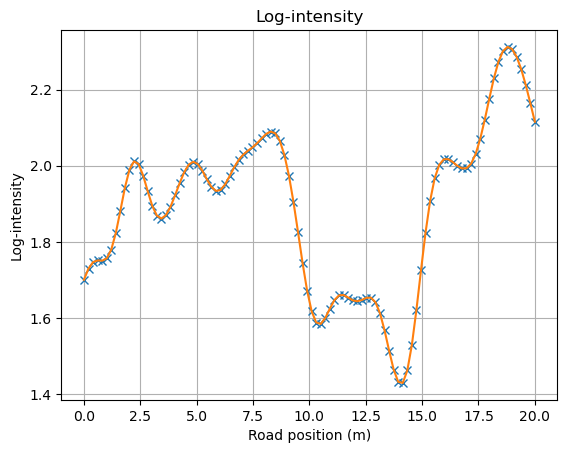

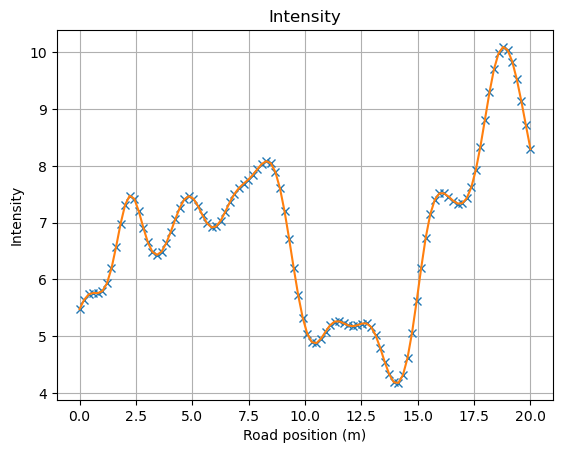

In [3]:
# Sample the log-intensity from GP
np.random.seed(6969)
log_intensity = sample_from_GP(xs, mean=2, var=5e-2, l=1)
plt.plot(xs, log_intensity, 'x')
plt.plot(xs, log_intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Log-intensity')
plt.title('Log-intensity')
plt.grid()
# intensity
intensity = np.exp(log_intensity)
plt.figure()
plt.plot(xs, intensity, 'x')
plt.plot(xs, intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Intensity')
plt.title('Intensity')
plt.grid()

In [4]:
print('Log-intensity: ', log_intensity)
print('Intensity: ', intensity)

Log-intensity:  [1.70054543 1.72998042 1.74684922 1.75120126 1.75061609 1.75671912
 1.77973736 1.82331    1.88196839 1.94265611 1.989774   2.01147645
 2.00430173 1.97408716 1.93303229 1.89465277 1.86916578 1.8611974
 1.8701447  1.89210543 1.92183835 1.95382297 1.98253597 2.00273691
 2.01041114 2.00424267 1.98673901 1.96402999 1.94403532 1.93367096
 1.93637005 1.95106086 1.97301766 1.99613047 2.01553518 2.02942048
 2.03921394 2.04811962 2.05880847 2.0714989  2.08339925 2.08964265
 2.08499364 2.06534258 2.0284652  1.97425521 1.90497267 1.82570682
 1.74457375 1.67183321 1.61753511 1.58829224 1.58463098 1.60042462
 1.6250119  1.64722998 1.65955451 1.66044908 1.65391769 1.64661999
 1.64402228 1.6474015  1.65299965 1.65357826 1.64158944 1.61261821
 1.5678085  1.51447706 1.46473878 1.43250797 1.42966768 1.46250406
 1.52957551 1.62185638 1.72523074 1.82448048 1.90728338 1.96679178
 2.00209396 2.01685313 2.01711812 2.00938774 1.99955597 1.99271774
 1.99333905 2.00519598 2.03076348 2.07022399 2.

In [5]:
# Sample vehicle positions from intensity using Poisson point process
n_vehicles = []
vehicle_positions = []
for segment in range(n_segments):
    # Sample number of vehicles in segment
    segment_n_vehicles = np.random.poisson(intensity[segment])
    # Add to list
    n_vehicles.append(segment_n_vehicles)
    # Sample vehicle positions in segment
    segment_vehicle_positions = np.random.uniform(0, segment_length, segment_n_vehicles)
    # Add segment offset
    segment_vehicle_positions += segment * segment_length
    # Add to list
    vehicle_positions.extend(segment_vehicle_positions)

# Convert to numpy array
vehicle_positions = np.array(vehicle_positions)
n_vehicles = np.array(n_vehicles)


# Generate measurements

Text(0.5, 1.0, 'Measurement Positions')

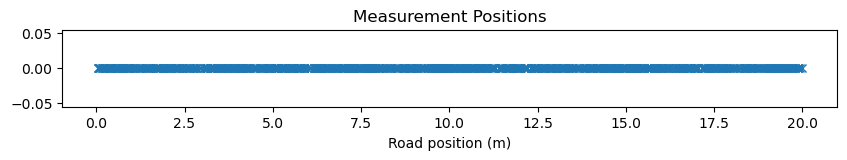

In [6]:
# Generate 20 measurements 
n_measurements = 1000
max_road_position = n_segments * segment_length
measurement_positions = np.random.uniform(0, max_road_position, n_measurements)
plt.figure(figsize=(10, 1))
plt.plot(measurement_positions, np.zeros_like(measurement_positions), 'x')
plt.xlabel('Road position (m)')
plt.title('Measurement Positions')

In [7]:
measurement_range = 0.1
measurement_segment_counts = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement
measurement_segment_counts_extrapolated = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement, extrapolated with the segment length
for i, measurement_position in enumerate(measurement_positions):
    # List all the vehicles in the measurement range
    in_range_bools = np.logical_and(vehicle_positions > measurement_position - measurement_range, vehicle_positions < measurement_position + measurement_range) # boolean array of all vehicles: True if in range
    in_range = vehicle_positions[in_range_bools] # list of vehicle positions in range
    # Count the number of vehicles in each segment
    segment_counts = np.zeros((n_segments,))
    segment_counts_extrapolated = np.zeros((n_segments,))
    for segment in range(n_segments):
        segment_counts[segment] = np.sum(np.logical_and(in_range > segment * segment_length, in_range < (segment + 1) * segment_length))
        if segment_counts[segment] > 0:
            # Find the length of the intersection between the segment and the measurement range
            segment_start = segment * segment_length
            segment_end = (segment + 1) * segment_length
            intersection_start = max(segment_start, measurement_position - measurement_range)
            intersection_end = min(segment_end, measurement_position + measurement_range)
            intersection_length = intersection_end - intersection_start
            # Extrapolate the number of vehicles in the segment using the intersection length
            segment_counts_extrapolated[segment] = segment_counts[segment] * segment_length / intersection_length
    measurement_segment_counts[i, :] = segment_counts
    measurement_segment_counts_extrapolated[i, :] = segment_counts_extrapolated

In [8]:
print('Meausrement Segment Counts Extrapolated (1 line = 1 measurement):\n', measurement_segment_counts_extrapolated)
print('Actual Segment Counts (1 line = 1 measurement):\n', n_vehicles)

Meausrement Segment Counts Extrapolated (1 line = 1 measurement):
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 7.46071837 0.         0.        ]]
Actual Segment Counts (1 line = 1 measurement):
 [ 7  4  6  6  8 11  7  8  5  9 10  9  6  7  5  7  6  3  5 10  6  5  9  8
  6  3  6  7  7  6  3  4  7  9  6 18  7  9  3  7  6 11  7  7  4 12  5  4
  3  3 11 10  5  4  5  7  6  1  7  4  5  3  2  0  4  4  6  7  2  3  3  3
  1  2  4  5  7  8  9  8  3  6  6  4  7 14  8  4  5  6  5 14 12  9 15 13
  8  8  8  6]


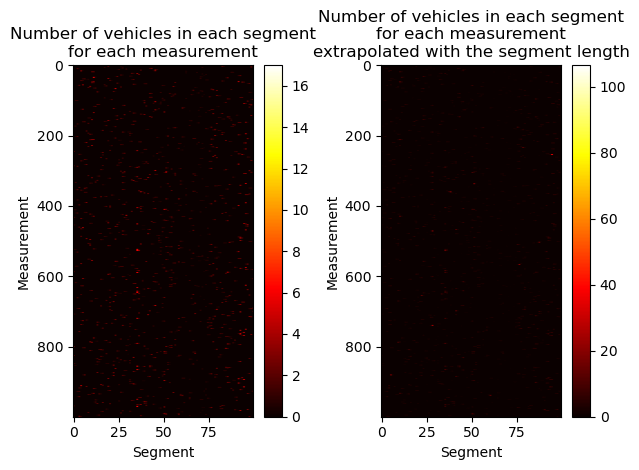

In [9]:
# Visualize the measurements
plt.subplot(1, 2, 1)
plt.imshow(measurement_segment_counts, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(measurement_segment_counts_extrapolated, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement\nextrapolated with the segment length')
plt.colorbar()
plt.tight_layout()

# tikz_save('prototype_lgcp_100s1000m.tex')

# Pseudo-inverse for Rank-deficient covariance matrices

In [10]:
def compute_rank(A, gain_cutoff = None, verbose = False):
    # SVD decomposition of A
    U, S, V = np.linalg.svd(A)
    # If gain_cutoff is not None, compute the rank_cutoff
    if gain_cutoff is not None:
        cum_S = np.cumsum(S)/np.sum(S)
        cum_S_diff = np.diff(cum_S)
        # Get the index of the first element that is smaller than the gain_cutoff
        rank_cutoff = np.argmax(cum_S_diff < gain_cutoff) + 1
        if verbose:
            print('Retain rank: ', rank_cutoff)
    else:
        rank_cutoff = None
    return rank_cutoff

def trim_rank(A, rank_cutoff = None, gain_cutoff = None, verbose = False):
    if gain_cutoff is not None and rank_cutoff is None:
        rank_cutoff = compute_rank(A, gain_cutoff, verbose)
    U, S, V = np.linalg.svd(A)
    # Trimming the rank
    U = U[:, :rank_cutoff]
    S = S[:rank_cutoff]
    V = V[:rank_cutoff, :]
    # Reconstructing A
    A = U @ np.diag(S) @ V
    return A

def psd_inv(A, rank_cutoff = None, gain_cutoff = None, verbose = False):
    if gain_cutoff is not None and rank_cutoff is None:
        rank_cutoff = compute_rank(A, gain_cutoff, verbose)
    U, S, V = np.linalg.svd(A)
    S_inv = np.zeros_like(S)
    S_inv[:rank_cutoff] = 1 / S[:rank_cutoff]
    # Reconstructing A_inv
    A_inv = V.T @ np.diag(S_inv) @ U.T
    return A_inv

# Inference

Posterior update for normal distributions

In [11]:
# Gaussian distribution posterior update
def gaussian_posterior_update_scalar(mean1, var1, mean2, var2):
    prec1 = 1/var1
    prec2 = 1/var2
    var = 1/(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var * (prec1 * mean1 + prec2 * mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update(mean1, var1, mean2, var2, inverter = 'bs_gain', rank_cutoff = 0, gain_cutoff = 0):
    if inverter == 'moore_penrose':
        prec1 = np.linalg.pinv(var1)
        prec2 = np.linalg.pinv(var2)
        var = np.linalg.pinv(prec1 + prec2)
    elif inverter == 'bs_gain':
        if gain_cutoff == 0:
            raise Exception('energy_gain parameter must be a positive integer when using the Bounded Singular Value Inverter')
        prec1 = psd_inv(var1, gain_cutoff=gain_cutoff)
        prec2 = psd_inv(var2, gain_cutoff=gain_cutoff)
        var = psd_inv(prec1 + prec2, gain_cutoff=gain_cutoff)
    elif inverter == 'bs_rank':
        if rank_cutoff == 0:
            raise Exception('rank_cutoff parameter must be a positive integer when using the Bounded Singular Value Inverter')
        prec1 = psd_inv(var1, rank_cutoff=rank_cutoff)
        prec2 = psd_inv(var2, rank_cutoff=rank_cutoff)
        var = psd_inv(prec1 + prec2, rank_cutoff=rank_cutoff)
    else:
        if inverter != 'default':
            print('WARNING: inverter parameter is not recognized, using np.linalg.inv')
        prec1 = np.linalg.inv(var1)
        prec2 = np.linalg.inv(var2)
        var = np.linalg.inv(prec1 + prec2)
    
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var @ (prec1 @ mean1 + prec2 @ mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update_list(means, vars, inverter = 'bs_gain', rank_cutoff = 0, gain_cutoff = 0):
    mean = means[0,:]
    var = vars[0,:,:]
    for i in range(1, means.shape[0]):
        # print('Iter B {}: mean = {}'.format(i, mean[:5]))
        mean, var = gaussian_posterior_update(mean, var, means[i,:], vars[i,:,:], inverter=inverter, rank_cutoff=rank_cutoff, gain_cutoff=gain_cutoff)
        # print('Iter A {}: mean = {}'.format(i, mean[:5]))
    return mean, var

Laplace approximation for Normal-Poisson observation model

In [12]:
def laplace_mean_through_fpi(rho_j, C_tilde_star, nj, mu_tilde_star, A, max_iter=100, tol=1e-9, verbose=False):
    y = np.zeros_like(mu_tilde_star) # initialize y
    one_j = np.zeros_like(mu_tilde_star)
    one_j[rho_j] = 1
    if verbose:
        print('Fixed Point Iteration for Laplace Mean started')
    for iter in range(max_iter):
        if verbose:
            print('Starting from y: {}'.format(y[:5]))
        y_new = mu_tilde_star + C_tilde_star @ ((nj - A*np.exp(y)) * one_j)
        if verbose:
            print('Delta y: {}'.format(C_tilde_star @ ((nj - A*np.exp(y)) * one_j)))
        if np.linalg.norm(y_new - y) < tol:
            if verbose:
                print('Converged')
                print('Error: {}'.format(np.linalg.norm(y_new-y)))
            break
        y = y_new
        if verbose:
            print('=>Iteration {}, y: {}'.format(iter, y[:5]))
            print('-----------------')
    
    if iter == max_iter - 1:
        print('WARNING: Fixed Point Iteration for Laplace Mean did not converge after {} iterations'.format(max_iter))
        print('Error: {}'.format(np.linalg.norm(y_new-y)))
    return y_new

def laplace_mean_through_newton(rho_j, C_tilde_star, nj, mu_tilde_star, A, max_iter=100, tol=1e-9, verbose=False):
    y = np.zeros_like(mu_tilde_star) # initialize y
    one_j = np.zeros_like(mu_tilde_star)
    one_j[rho_j] = 1
    P_tilde_star = np.linalg.pinv(C_tilde_star)

    if verbose:
        print('=== Newton Iteration for Laplace Mean started ===')
    for iter in range(max_iter):
        if verbose:
            print('Starting from y: {}'.format(y[:5]))
        # Compute the Jacobian matrix
        Z = np.zeros((len(y), len(y)))
        Z[:, rho_j] = -P_tilde_star[:,rho_j] * A * np.exp(y[rho_j])
        Df = -np.eye(len(y)) + Z
        
        # Newton update step
        y_new = y - np.linalg.pinv(Df) @ (-y + mu_tilde_star + P_tilde_star @ ((nj - A*np.exp(y[rho_j])) * one_j))
        if verbose:
            # print('Df:\n', Df)
            # print('Delta y: {}'.format(y_new - y))
            pass
        if np.linalg.norm(y_new - y) < tol:
            if verbose:
                print('Converged')
                print('Error: {}'.format(np.linalg.norm(y_new-y)))
                print('=> Iteration {}, y: {}'.format(iter, y[:5]))
                print('-----------------')
            break
        y = y_new
        if verbose:
            print('=> Iteration {}, y: {}'.format(iter, y[:5]))
            print('-----------------')
    
    if iter == max_iter - 1:
        # print('WARNING: Newton Iteration for Laplace Mean did not converge after {} iterations'.format(max_iter))
        # print rho_j, C_tilde_star, nj, mu_tilde_star
        print('rho_j = {}'.format(rho_j))
        print('C_tilde_star = {}'.format(C_tilde_star))
        print('nj = {}'.format(nj))
        print('mu_tilde_star = {}'.format(mu_tilde_star))
        raise Exception('Newton Iteration for Laplace Mean did not converge after {} iterations'.format(max_iter))
        print('=== Newton Iteration for Laplace Mean ended unexpectedly ===')

    if verbose:
        print('=== Newton Iteration for Laplace Mean ended ===')
    return y_new

def laplace_var(rho_j, C_tilde_star, A, y, verbose=False):
    res = -np.linalg.inv(C_tilde_star)
    res[rho_j, rho_j] -= A*np.exp(y[rho_j])
    return -np.linalg.inv(res)

Expectation Propagation

In [13]:
from gp import gram_matrix
# Expectation Propagation (EP)

# Initialize the EP parameters
# Intractable component approximators / log-likelihood
mu_tildes = np.zeros((n_measurements, n_segments))
var_tildes = np.zeros((n_measurements, n_segments, n_segments))
for i in range(n_measurements):
    # var_tildes[i, :, :] = np.eye(n_segments) * 1e-3
    var_tildes[i, :, :] = np.zeros((n_segments, n_segments)) 

# Tractable components approximator / prior
mu_zero = np.ones((n_segments,)) * 0
# var_zero = gram_matrix(xs, var=5e-1, l=2)
# var_zero = np.eye(n_segments) * 3. # diagonal covariance
var_zero = gram_matrix(xs, var=9, l=15) # full covariance 

Switching to the RBF covariance function, we see that the covariance matrix is close to being singular. Inverting this matrix is very difficult.

In [14]:
from tqdm import tqdm

# Algorithm Hyperparameters
max_ep_iterations = 1
verbose = True 
np.random.seed(6969)
use_moore_penrose = True
update_natural_params = True
gain_cutoff = 0.05 # to approximate the singular covariance matrix to 95% energy

# Output variables history through the iterations
mu_tildes_history = np.zeros((max_ep_iterations, n_measurements, n_segments))
var_tildes_history = np.zeros((max_ep_iterations, n_measurements, n_segments, n_segments))
mu_posterior_history = np.zeros((max_ep_iterations, n_segments))
var_posterior_history = np.zeros((max_ep_iterations, n_segments, n_segments))
segments_seen_by_ep = []
measurements_seen_by_ep = []

for ep_iteration in (pbar := tqdm(range(max_ep_iterations))):
    
    # Choose a random measurement index j component to refine
    j = np.random.randint(0, n_measurements)
    measurements_seen_by_ep.append(j)
    
    # ==================    q_minus_j    ==================
    q_minus_j_means_param = np.concatenate((mu_zero.reshape((1,-1)), np.delete(mu_tildes, j, axis=0)))
    q_minus_j_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), np.delete(var_tildes, j, axis=0)))
    mu_q_minus_j, var_q_minus_j = gaussian_posterior_update_list(means = q_minus_j_means_param, vars = q_minus_j_vars_param,
                                                                 inverter = 'bs_gain', rank_cutoff = 0, gain_cutoff = 0)
    
    # ==================    Tilted Distribution    ==================
    measurement_segment_counts_extrapolated_j = measurement_segment_counts_extrapolated[j, :]
    # Segment index is the first non-zero element
    segment_index_j = np.argmax(measurement_segment_counts_extrapolated_j > 0)
    segments_seen_by_ep.append(segment_index_j)
    # Number of vehicles in the segment
    nj = measurement_segment_counts_extrapolated_j[segment_index_j]
    # Rename the variables so that they are consistent with the paper
    # q_minus_j's covariance matrix and mean vector
    C_tilde_star = var_q_minus_j
    mu_tilde_star = mu_q_minus_j
    # A is the segment length
    A = 1 # TODO: Change this to the actual segment length
    # Index of the segment to be updated with Laplace approximation
    rho_j = segment_index_j

    # Print the parameters
    if verbose:
        print('=== Tilted Distribution Parameters ===')
        print('j / Index of Measurement: {}'.format(j))
        print('rho_j / Index of Segment: {}'.format(rho_j))
        print('nj / Segment Count: {}'.format(nj))
        print('A / Segment Length (**assumed to be 1**): {}'.format(A))
        print('mu_tilde_star / q_minus_j mean: {}'.format(mu_tilde_star[:5]))
        print('C_tilde_star / q_minus_j var:\n{}'.format(C_tilde_star[:5,:5]))
        print('=======================================')
    
    # ==================    Laplace Approximation of Tilted Distribution    ==================
    lmean = laplace_mean_through_newton(rho_j, C_tilde_star, nj, mu_tilde_star, A, verbose=verbose)
    lvar = laplace_var(rho_j, C_tilde_star, A, lmean, verbose=verbose)
    
    # ==================    Update the EP parameters    ==================
    
    # Derive the natural parameters of the jth intractable component
    # The precision matrices
    
    if use_moore_penrose:
        lvar_inv = np.linalg.pinv(lvar)
        C_tilde_star_inv = np.linalg.pinv(C_tilde_star)
        iter_var_difference_inv = lvar_inv - C_tilde_star_inv
        iter_var_difference = np.linalg.pinv(iter_var_difference_inv)
    else:
        lvar_inv = np.linalg.inv(lvar)
        C_tilde_star_inv = np.linalg.inv(C_tilde_star)
        iter_var_difference_inv = lvar_inv - C_tilde_star_inv
        iter_var_difference = np.linalg.inv(iter_var_difference_inv)

    iter_mean_difference = iter_var_difference @ (lvar_inv @ lmean - C_tilde_star_inv @ mu_tilde_star)
    
    # Update the EP parameters
    if update_natural_params:
        mu_tildes[j, :] = iter_mean_difference # replace the jth intractable component with Laplace mean
        var_tildes[j, :, :] = iter_var_difference
    
    if verbose:
        print('-----------------')
        print('Mean imitator set to: {}'.format(mu_tildes[j, :]))
        print('Var imitator set to:\n{}'.format(var_tildes[j, :, :]))
        print('-----------------')
        print('Laplace mean: {}'.format(lmean))
        print('Laplace var:\n{}'.format(lvar))
        print('-----------------')

    # Calculate the posterior distribution
    q_means_param = np.concatenate((mu_zero.reshape((1,-1)), mu_tildes))
    q_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), var_tildes))
    mu_q, var_q = gaussian_posterior_update_list(means = q_means_param, vars = q_vars_param)
    # Store the posterior parameters in the history variables
    mu_tildes_history[ep_iteration, :, :] = mu_tildes
    var_tildes_history[ep_iteration, :, :, :] = var_tildes
    mu_posterior_history[ep_iteration, :] = mu_q
    var_posterior_history[ep_iteration, :, :] = var_q
    
    # Show the difference between subsequent iterations, also a condition for convergence
    delta_diff_of_mean = np.linalg.norm(iter_mean_difference)
    tqdm.set_description(pbar, 'Delta diff of mean: {}'.format(delta_diff_of_mean))

  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: gaussian_posterior_update_list() got an unexpected keyword argument 'use_moore_penrose'

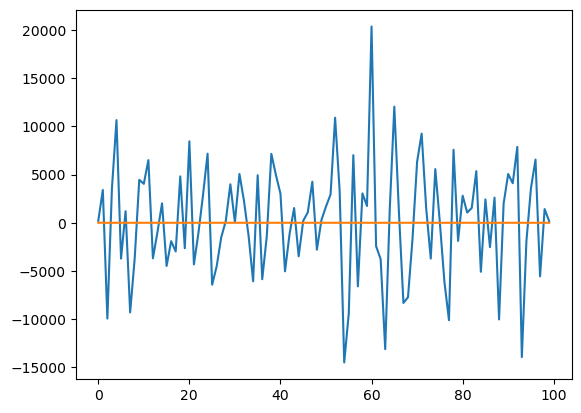

In [29]:
plt.plot(mu_q, label='Imitating means')
plt.plot(lmean, label='Laplace means')

**Something went wrong calculating the imitating distribution**

In [33]:
print('Largest eigenvalue of Laplace var: ', np.linalg.eigvals(lvar)[0])
print('Largest eigenvalue of Prior var: ', np.linalg.eigvals(var_zero)[0])

Largest eigenvalue of Laplace var:  (-81.69344535021204+10.89830717925059j)
Largest eigenvalue of Prior var:  (383.2404669612544+0j)


# Scratch ==================================================

Text(0.5, 1.0, 'Prior var inverse')

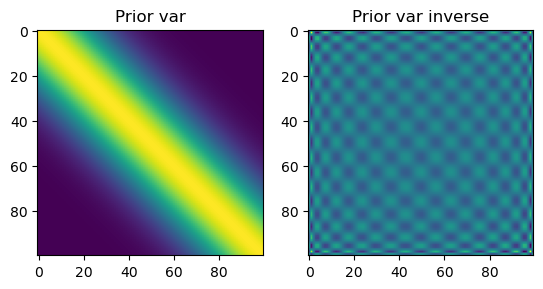

In [40]:
plt.subplot(1,2,1)
plt.imshow(var_zero)
plt.title('Prior var')
plt.subplot(1,2,2)
plt.imshow(np.linalg.pinv(var_zero))
plt.title('Prior var inverse')

Singular values of var_zero:  [3.83240467e+02 2.67459681e+02 1.48356330e+02 6.63845605e+01
 2.44292084e+01 7.55128892e+00 2.00074179e+00 4.62424647e-01
 9.45938803e-02 1.73301058e-02]


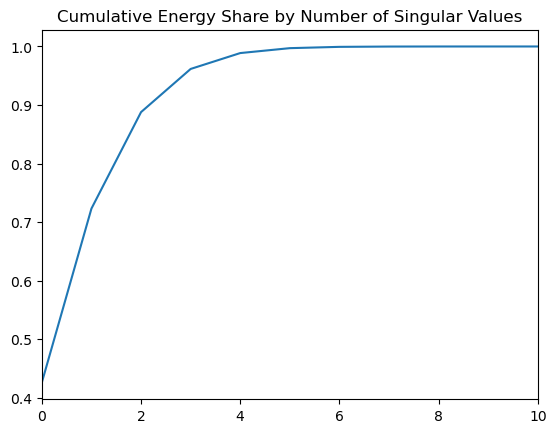

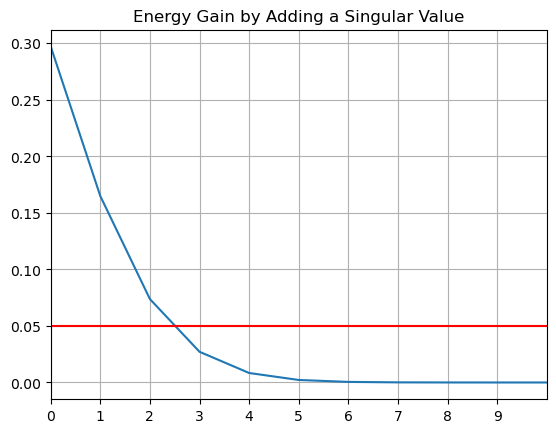

In [58]:
# SVD decomposition of var_zero
U, S, V = np.linalg.svd(var_zero)
print('Singular values of var_zero: ', S[:10])
# Cumulative sum of the singular values
cumsum_S = np.cumsum(S)/np.sum(S)
plt.plot(cumsum_S)
plt.xlim((0,10))
plt.title('Cumulative Energy Share by Number of Singular Values')
plt.figure()
plt.plot(np.diff(cumsum_S))
plt.xlim((0,10))
plt.title('Energy Gain by Adding a Singular Value')
# draw a horizontal line y=0.05
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(np.arange(0, 10, 1.0))
plt.grid()
plt.show()

# End of Scratch ==================================================

In [ ]:
# Show segment indices seen by EP
print('Segments seen by EP: {}'.format(np.unique(segments_seen_by_ep)))
# Show measurement indices seen by EP
print('Measurements seen by EP: {}'.format(np.unique(measurements_seen_by_ep)))

In [ ]:
# Compute the confidence interval
ci_q = np.sqrt(np.diag(var_q))
# Only retain the points of mu_q that are different from mu_zero
mu_q_nonzero = mu_q[mu_q != mu_zero]
# and the indices of the points
mu_q_nonzero_indices = np.where(mu_q != mu_zero)[0]
ci_q_nonzero = ci_q[mu_q_nonzero_indices]

plt.plot(mu_q_nonzero_indices, mu_q_nonzero, 'x')
plt.plot(mu_q_nonzero_indices, mu_q_nonzero, 'k')
plt.fill_between(mu_q_nonzero_indices, mu_q_nonzero - ci_q_nonzero, mu_q_nonzero + ci_q_nonzero, alpha=0.2)
plt.title('Posterior mean and confidence interval')
plt.xlabel('Segment index')
plt.ylabel('Log-intensity')
# Plot the true log-intensity curve
plt.plot(log_intensity)

In [ ]:
# Similarly, but this time with actual intensity rather than log-intensity
ci_q = np.exp(np.sqrt(np.diag(var_q)))
# Only retain the points of mu_q that are different from mu_zero
mu_q_nonzero = np.exp(mu_q[mu_q != mu_zero])
# and the indices of the points
mu_q_nonzero_indices = np.where(mu_q != mu_zero)[0]
ci_q_nonzero = ci_q[mu_q_nonzero_indices]

plt.plot(mu_q_nonzero_indices, mu_q_nonzero, 'x')
plt.plot(mu_q_nonzero_indices, mu_q_nonzero, 'k')
plt.fill_between(mu_q_nonzero_indices, mu_q_nonzero - ci_q_nonzero, mu_q_nonzero + ci_q_nonzero, alpha=0.2)
plt.title('Posterior mean and confidence interval')
plt.xlabel('Segment index')
plt.ylabel('Intensity')
# Plot the true log-intensity curve
plt.plot(intensity)

In [ ]:
# Plot the historical parameters
plt.figure(figsize=(5, 5))
plt.plot(np.arange(max_ep_iterations), mu_posterior_history[:, 0], label='First segment')
plt.plot(np.arange(max_ep_iterations), mu_posterior_history[:, 1], label='Second segment')
# plt.xticks(np.arange(0, max_ep_iterations, 1))
plt.xlabel('EP Iteration')
plt.ylabel('Log-intensity')
# Show the ground truth
# repeat the ground truth log-intensity for the number of EP iterations
plt.plot(np.arange(max_ep_iterations), np.repeat(log_intensity[0], max_ep_iterations, axis=0), label='First segment (ground truth)')
plt.plot(np.arange(max_ep_iterations), np.repeat(log_intensity[1], max_ep_iterations, axis=0), label='Second segment (ground truth)')
plt.legend()

plt.figure(figsize=(5, 5))
# Plotting the spectral norm of the posterior covariance matrix
plt.plot(np.arange(max_ep_iterations), np.array([np.linalg.eigvals(var_posterior_history[i, :, :])[0] for i in range(max_ep_iterations)]), label='First segment')
plt.plot(np.arange(max_ep_iterations), np.array([np.linalg.eigvals(var_posterior_history[i, :, :])[1] for i in range(max_ep_iterations)]), label='Second segment')
plt.legend()
plt.xlabel('EP Iteration')
plt.ylabel('Spectral norm of posterior covariance matrix')

# tikz_save('ep_convergence.tex', axis_width='9cm', axis_height='9cm')

# Demonstration of the Laplace approximation

In [ ]:
from scipy.stats import multivariate_normal

# ==================    Test    ==================
n_samples = 10_000
# uniformly sample from a 2d uniform distribution
particles = np.random.uniform(low=.1, high=5., size=(n_samples, 2))
# Normal-Poisson (the tilted distribution)
normal_poisson = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star) * np.exp(nj * particles[:, 1] - A * np.exp(particles[:, 1]))
normal_poisson /= np.sum(normal_poisson)
# The j-excluded normal distribution
normal = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star)
normal /= np.sum(normal)
# The imitating distribution by Laplace approximation
imitating = multivariate_normal.pdf(particles, mean=lmean, cov=lvar)
imitating /= np.sum(imitating)

# 3d histogram
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
ax.scatter(particles[:, 0], particles[:, 1], normal_poisson, s=1, c='r')
ax.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax.set_title('Normal-Poisson')
ax2 = fig.add_subplot(222, projection='3d')
# ax.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax2.scatter(particles[:, 0], particles[:, 1], imitating, s=1, c='g')
ax2.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax2.set_title('Imitating')
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(particles[:, 0], particles[:, 1], normal_poisson, s=1, c='r')
ax3.scatter(particles[:, 0], particles[:, 1], imitating, s=1, c='g')
ax3.set_title('Normal-Poisson vs. Imitating')
plt.tight_layout()
plt.show()


So, the imitating distribution approximates the tilted distribution very well. 